In [11]:
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups
import re, warnings
import scattertext as ST
from pandas.core.common import SettingWithCopyWarning
import spacy
import mpld3
import matplotlib.pyplot as plt
mpld3.enable_notebook()
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
nlp = spacy.en.English()

## Load newsgroup dataset

In [3]:
categories = ['alt.atheism', 'talk.religion.misc']
newsgroups = fetch_20newsgroups(subset='train', categories=categories)

In [4]:
# function to strip out headers from newsgroup posts, remove last full line
def clean_newsgroup_data_factory():
    badline_re = re.compile(r'(^(>|From:|Subject:|Organization:'+
                            '|Distribution:|NNTP-Posting-Host:|Lines:|News-Software:'
                            +'|In article <.+?@.+>)|(writes:?|.com|.edu|.org)$)')
    email_address_finder = re.compile(r'\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}\b', flags=re.IGNORECASE)
    def clean_newsgroup_data(text):
        return '\n'.join([email_address_finder.sub('', line)
                          for line in text.split('\n') 
                          if badline_re.match(line.strip()) is None][:-1])
    return clean_newsgroup_data

In [5]:
term_doc_matrix_factory = ST.TermDocMatrixFactory(
        category_text_iter = ((categories[idx], text) 
                              for idx, text 
                              in zip(newsgroups.target, newsgroups.data)), # only pass in full category names
        clean_function = clean_newsgroup_data_factory(),
        nlp = nlp)
term_doc_matrix = term_doc_matrix_factory.build()


# See what stands out in the data set against English as a whole

In [6]:
(term_doc_matrix
 .get_scaled_f_score_scores_vs_background()
 .iloc[:10])
# we can also use get_rudder_scores_vs_background, 
# get_posterior_mean_ratio_scores_vs_background, 
# or get_fisher_scores_vs_background

/Users/kesslej/anaconda3/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/kesslej/anaconda3/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


,corpus,background,Scaled f-score
koresh,87.0,73785.0,0.000653
ksand,42.0,0.0,0.000436
atheists,168.0,795807.0,0.000340
decenso,32.0,0.0,0.000332
mozumder,32.0,0.0,0.000332
alink,42.0,60976.0,0.000331
livesey,42.0,78135.0,0.000310
halat,28.0,0.0,0.000290
beauchaine,27.0,0.0,0.000280
atheism,158.0,1022796.0,0.000260


## See what distinguishes alt.atheism against talk.religion.misc, in terms of Scaled F-Score

In [7]:
df = term_doc_matrix.get_term_freq_df()
df['Scaled f-score'] = term_doc_matrix.get_scaled_f_scores('alt.atheism', scaler_algo = 'percentile')

In [8]:
# other options include get_logistic_regression_coefs_l1, get_rudder_scores, 
#  get_posterior_mean_ratio_scores, and get_fisher_scores
df.sort_values('Scaled f-score', ascending = False).iloc[:10]

,alt.atheism freq,talk.religion.misc freq,Scaled f-score
term,,,
fallacy,59,0,0.803535
atheists,163,5,0.796854
keith,81,2,0.796624
atheist,100,3,0.795846
atheism,153,5,0.794672
bobby,45,0,0.778154
atheism is,36,0,0.753395
g'd,35,0,0.750156
jon,74,5,0.746738


## In terms of distinguishing l2-penalized logistic regression coefs

In [15]:
df['L2 coefs'], acc, baseline = term_doc_matrix.get_logistic_regression_coefs_l2('alt.atheism')
print('classifier accuracy', acc)
print('majority-class baseline accuracy', baseline)
df.sort_values('L2 coefs', ascending=False).iloc[:10]

classifier accuracy 0.83430571762
majority-class baseline accuracy 0.560093348891


,alt.atheism freq,talk.religion.misc freq,Scaled f-score,L2 coefs
term,,,,
keith,81,2,0.796624,1.665221
tammy,19,0,0.682902,1.191716
atheism,153,5,0.794672,1.126428
gregg,30,0,0.732356,1.119330
jon,74,5,0.746738,1.058742
benedikt,37,1,0.732827,1.010725
it,1557,1043,0.207731,1.007258
islam,110,19,0.632731,0.997842
atheist,100,3,0.795846,0.868914


## The rudder visualization, with posterior ratios as scores.  Write interactive chart and term rankings to alt.atheism.html.

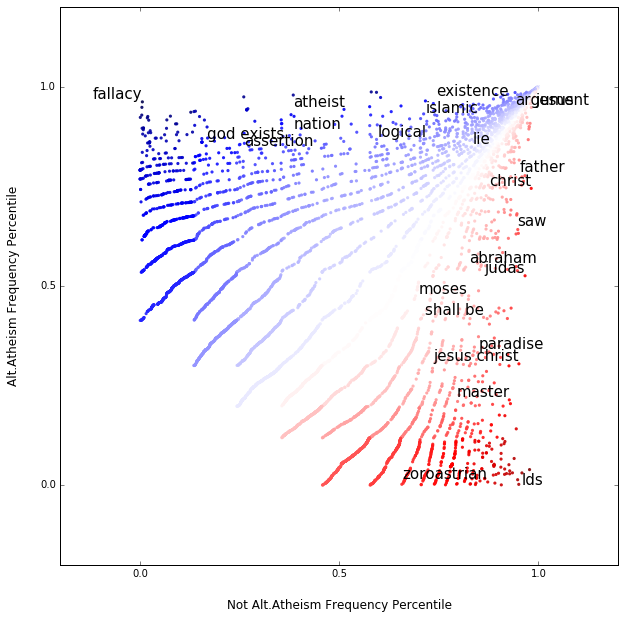

In [16]:
import scattertext as ST
plt.rcParams['figure.figsize'] = (10, 10)
scatter_chart = ST.ScatterChart(term_doc_matrix,
                                jitter = 0, # 0.05 adds a bit of jitter
                               )
chart_df, chart_html = scatter_chart.draw('alt.atheism',
                      num_top_words_to_annotate = 0,
                      transform = ST.Scalers.percentile_ordinal,
                      scores = term_doc_matrix.get_posterior_mean_ratio_scores('alt.atheism'),
                      words_to_annotate=['lds', 'fallacy', 'assertion', 'god exists', 'logical', 'lie', 'existence', 
                                         'atheist', 'saw', 'shall be', 'paradise', 'argument', 'islamic', 'nation', 
                                         'master', 'jesus', 'abraham', 'moses', 'christ', 'jesus christ',
                                        'judas', 'father', '', 'zoroastrian'])
visualization_fn = open('alt.atheism.html', 'w')
visualization_fn.write(chart_html)
print('<h2>Top terms</h2>', file=visualization_fn)
chart_df.sort_values(by='color_scores', ascending=False)[:30].to_html(visualization_fn)
print('<h2>Bottom terms</h2>', file=visualization_fn)
chart_df.sort_values(by='color_scores', ascending=False)[-30:].to_html(visualization_fn)
visualization_fn.close()